In [1]:
import os
import librosa
import librosa.display
import numpy as np
import keras
import pickle
from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from python_speech_features import base as speech
from scipy import signal as s
%matplotlib inline

/home/lovely/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot(arg, t=None):
    plt.figure(figsize=(8,5))
    librosa.display.specshow(arg, x_axis='time',cmap='jet')
    plt.colorbar()
    if t: 
        plt.title(t)
    plt.tight_layout()

In [3]:
# !ls RAVDESS/0_all_speech

In [4]:
!ls

0_all_wav_data			  Mp4ToWav.ipynb
0_mfcc_speech_only.ipynb	  pkls
1_spectrograms			  RAVDESS
1_with_spectrograms.ipynb	  resources
2_mfccs_conv1D.ipynb		  sandbox.ipynb
computing_MFCC_experiments.ipynb  spectrograms_generating.ipynb
computing_MFCC.ipynb		  spectrograms.ipynb
custom_alexnet_batchnorm.ipynb	  spectr_vs_cepstr.ipynb
files_renaming.ipynb		  start_try_1.ipynb
local_simple			  test_1.ipynb
mfcc_generating.ipynb		  test_2.ipynb
models				  test.png


In [5]:
path = '0_all_wav_data/'
min_sig_len = 64745 # 140941 
max_sig_len = 116660 # 253053

In [6]:
import os
len(os.listdir('0_all_wav_data'))

4260

In [7]:
# librosa.load??

In [8]:
%%time

features_file_name = 'extended_0pad_power1_norm1_db' + '.pkl'

classes = np.array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'sad', 'surprised','neutral']) 
num_of_classes = len(classes)

# all_mel_specs = []
# all_class_labels = []

print('Features: ')

if features_file_name in os.listdir('./pkls'):
        print('Reading features from file...')
        
        with open('./pkls/' + features_file_name, 'rb') as f:
                all_mel_specs = pickle.load(f)
        
        with open('./pkls/' + 'all_class_labels.pkl', 'rb') as f:
                all_class_labels = pickle.load(f)
else: 
        print('Computing mel spectrograms for all files...')

        all_mel_specs = []
        all_class_labels = []

        for file in os.listdir(path):
            class_label = file.split('-')[0]

            # if not 'neutral' in class_label:
            signal, samplerate = librosa.core.load(path+file, res_type='kaiser_fast')
            class_label = np.where(classes == class_label)[0][0]

            signal = np.pad(signal,(0,max_sig_len-len(signal)), mode='constant')

            all_mel_specs.append(librosa.amplitude_to_db(librosa.feature.melspectrogram(
                signal, 
                sr=samplerate, 
                power=1,
                norm=1,
            )))

            all_class_labels.append(class_label)

        with open('./pkls/' + features_file_name, 'wb') as f:
                pickle.dump(all_mel_specs, f)

        with open('./pkls/' + 'extended_all_class_labels.pkl', 'wb') as f:
                pickle.dump(all_class_labels, f)

Features: 
Computing mel spectrograms for all files...
CPU times: user 28min 29s, sys: 29.7 s, total: 28min 59s
Wall time: 7min 20s


In [9]:
len(all_mel_specs)

4260

In [10]:
len(all_class_labels)

4260

In [11]:
np.array(all_mel_specs).shape

(4260, 128, 228)

In [12]:
ls 0_all_wav_data

angry-normal-female-1033.wav*    fearful-strong-male-1118.wav*
angry-normal-female-1035.wav*    fearful-strong-male-1119.wav*
angry-normal-female-1052.wav*    fearful-strong-male-1129.wav*
angry-normal-female-1065.wav*    fearful-strong-male-1224.wav*
angry-normal-female-110.wav*     fearful-strong-male-1240.wav*
angry-normal-female-1150.wav*    fearful-strong-male-1246.wav*
angry-normal-female-1152.wav*    fearful-strong-male-1253.wav*
angry-normal-female-1156.wav*    fearful-strong-male-1273.wav*
angry-normal-female-1181.wav*    fearful-strong-male-1298.wav*
angry-normal-female-126.wav*     fearful-strong-male-1301.wav*
angry-normal-female-137.wav*     fearful-strong-male-1310.wav*
angry-normal-female-1398.wav*    fearful-strong-male-1336.wav*
angry-normal-female-1408.wav*    fearful-strong-male-1366.wav*
angry-normal-female-1417.wav*    fearful-strong-male-1374.wav*
angry-normal-female-1429.wav*    fearful-strong-male-1379.wav*
angry-normal-female-142.wav*     fearful-strong-male-14

calm-normal-male-202.wav*        neutral-normal-female-2083.wav
calm-normal-male-2035.wav        neutral-normal-female-2134.wav
calm-normal-male-204.wav*        neutral-normal-female-2149.wav
calm-normal-male-2059.wav        neutral-normal-female-2150.wav
calm-normal-male-2062.wav        neutral-normal-female-2154.wav
calm-normal-male-2066.wav        neutral-normal-female-2162.wav
calm-normal-male-2096.wav        neutral-normal-female-2246.wav
calm-normal-male-2174.wav        neutral-normal-female-2248.wav
calm-normal-male-2193.wav        neutral-normal-female-2371.wav
calm-normal-male-222.wav*        neutral-normal-female-2385.wav
calm-normal-male-2261.wav        neutral-normal-female-2393.wav
calm-normal-male-2270.wav        neutral-normal-female-2445.wav
calm-normal-male-2284.wav        neutral-normal-female-2454.wav
calm-normal-male-2287.wav        neutral-normal-female-246.wav*
calm-normal-male-2288.wav        neutral-normal-female-2499.wav
calm-normal-male-2292.wav        neutral

In [13]:
#  files for comparing
# ls = ['angry-normal-female-1408.wav',
#       'fearful-strong-male-1310.wav',
#       'angry-strong-male-42.wav',
#       'happy-strong-female-244.wav',
#      'calm-strong-female-1160.wav']

ls = ['angry-normal-female-1841.wav']

In [14]:
path+file

'0_all_wav_data/sad-strong-female-363.wav'

In [ ]:
n_fft=2048, hop_length=512
# n_fft=1024 * 5

In [28]:
librosa.filters.mel??

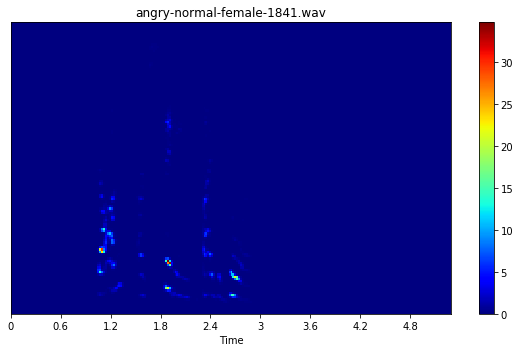

In [16]:
for f in ls:
    signal, samplerate = librosa.core.load(path + f, res_type='kaiser_fast')
    signal = np.pad(signal,(0,max_sig_len-len(signal)), mode='constant')
    a = librosa.feature.melspectrogram(signal, sr=samplerate)
    plot(a, f)

In [23]:
librosa.feature.melspectrogram??

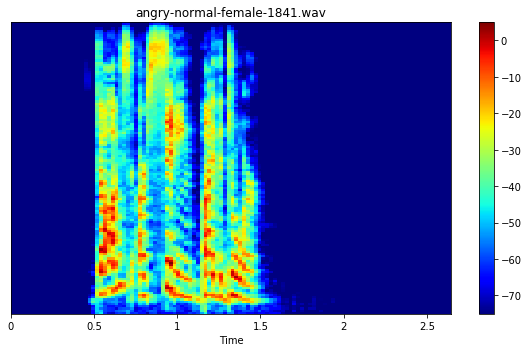

In [17]:
for f in ls:
    signal, samplerate = librosa.core.load(path + f, res_type='kaiser_fast')
    signal = np.pad(signal,(0,max_sig_len-len(signal)), mode='constant')
    a = librosa.amplitude_to_db(librosa.feature.melspectrogram(signal, 
                                                               sr=samplerate, 
                                                               power=1,
                                                               norm=1,
                                                               hop_length=round(512*2)
                                                              ))
    plot(a, f)

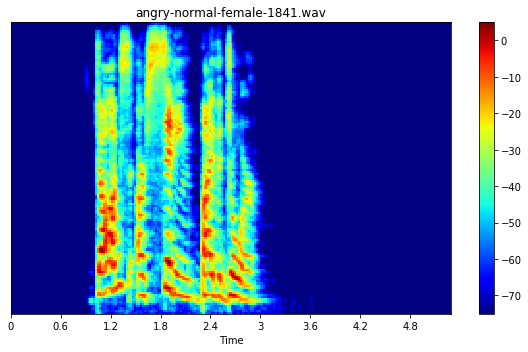

In [18]:
res = []
for f in ls:
    signal, samplerate = librosa.core.load(path + f, res_type='kaiser_fast')
    signal = np.pad(signal,(0,max_sig_len-len(signal)), mode='constant')
    a = librosa.amplitude_to_db(librosa.feature.melspectrogram(signal, 
                                                               sr=samplerate, 
                                                               power=1,
                                                               norm=1,
                                                              ))
    res.append(a)
    plot(a, f)

In [19]:
res = np.array(res)

In [20]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [21]:
min_ =  np.amin(res)
max_ = np.amax(res)

In [22]:
res = (res - min_) / (max_ - min_) * 255

In [23]:
res = res.astype('int')

In [24]:
res.dtype

dtype('int64')

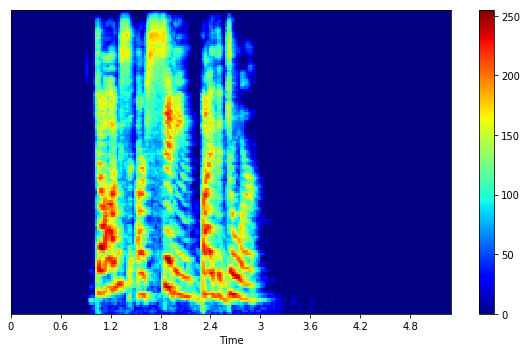

In [25]:
for a in res:
    plot(a)

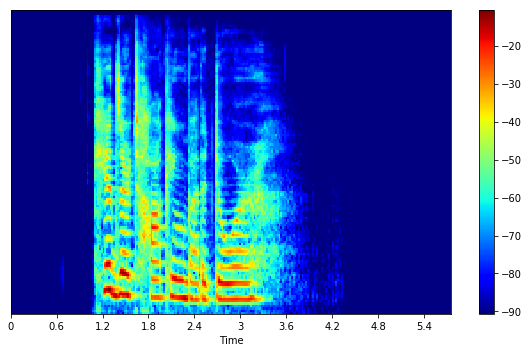

In [22]:
plot(a)

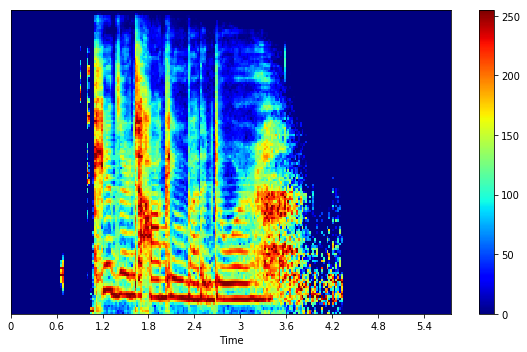

In [21]:
plot(scaler.fit_transform(a) * 255)

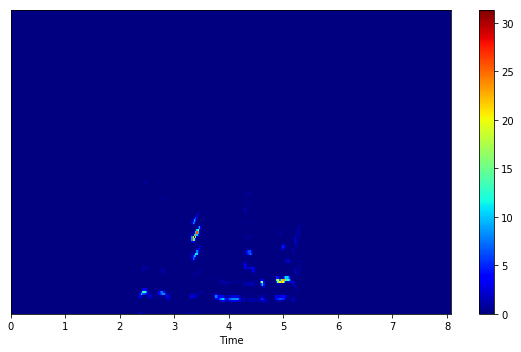

In [13]:
signal, samplerate = librosa.core.load(path + ls[0], sr=48000)
a = librosa.feature.melspectrogram(signal, sr=samplerate)
plot(a)

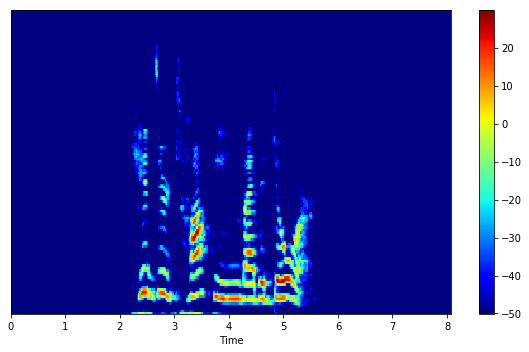

In [14]:
signal, samplerate = librosa.core.load(path + ls[0], sr=48000)
a = librosa.amplitude_to_db(librosa.feature.melspectrogram(signal, sr=samplerate))
plot(a)

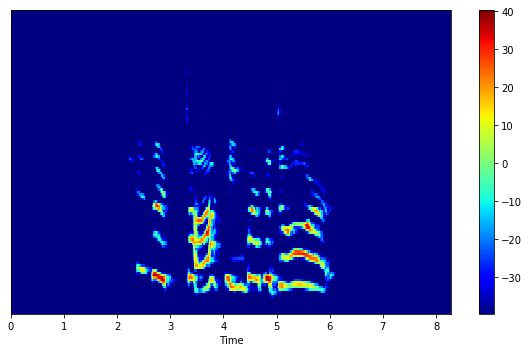

In [15]:
signal, samplerate = librosa.core.load(path+file, sr=48000)
a = librosa.amplitude_to_db(librosa.feature.melspectrogram(signal, sr=samplerate))
plot(a)

In [5]:
librosa.feature.melspectrogram

In [ ]:
ref_power=1.0

In [6]:
layers.Conv1D??

In [11]:
if '0':
    print(1)

1


In [15]:
if 0:
    print(1)

In [ ]:
# apply mel-spectrogram
# apply db filter to mel spectrogram

In [ ]:
# librosa.amplitude_to_db(b)